In [ ]:
import kagglehub
import os
import pickle
import numpy as np
import pandas as pd
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

################################################################
#       CHANGE THIS TO YOUR LOCAL DIRECTORY PATH               #
dir_path = '/content/drive/MyDrive/Colab Notebooks/COSC 760 project/2. STGCN'
################################################################

model_name = 'STGCN'

In [ ]:
def normalize_adj(adj, eps=1e-5):
    A = adj + torch.eye(adj.size(0), device=adj.device)
    D = A.sum(-1)
    D_inv_sqrt = (D + eps).pow(-0.5)
    A_norm = D_inv_sqrt[:, None] * A * D_inv_sqrt[None, :]
    return A_norm


class STGCNBlock(nn.Module):
    def __init__(self, in_feats, spatial_feats, gcn_feats, adj_matrix, kernel_size=3):
        super().__init__()

        self.temp1 = nn.Conv1d(
            in_feats, spatial_feats,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )

        self.register_buffer("A_hat", normalize_adj(adj_matrix))

        self.W = nn.Parameter(torch.randn(spatial_feats, gcn_feats))

        self.temp2 = nn.Conv1d(
            gcn_feats, spatial_feats,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )

        self.relu = nn.ReLU()

    def forward(self, x):
        # x: (B, T, N, F)
        if x.ndim == 3:
            x = x.unsqueeze(-1)

        B, T, N, F = x.shape
        A = self.A_hat

        # ---- Temporal Conv 1 ----
        x = x.permute(0, 2, 3, 1)              # (B, N, F, T)
        x = x.reshape(B*N, F, T)
        x = self.temp1(x)                      # (B*N, spatial_feats, T)
        S = x.shape[1]                         # spatial_feats

        # reshape for GCN
        x = x.reshape(B, N, S, T).permute(0, 3, 1, 2)  # (B, T, N, S)

        # ---- Graph Convolution ----
        x = torch.einsum("ij,btjf->btif", A, x)        # A X
        x = torch.einsum("btif,fh->btih", x, self.W)   # (A X) W

        # ---- Temporal Conv 2 ----
        x = x.permute(0, 2, 3, 1)              # (B, N, gcn_feats, T)
        x = x.reshape(B*N, self.W.shape[1], T)
        x = self.temp2(x)                      # (B*N, S, T)

        # reshape back
        x = x.reshape(B, N, S, T).permute(0, 3, 1, 2)  # (B, T, N, S)

        return self.relu(x)


class STGCN(nn.Module):
    def __init__(self, input_size, hidden_size, gcn_channels, num_layers,
                 horizon, output_size, adj_matrix):
        super().__init__()

        layers = []
        in_dim = input_size

        for _ in range(num_layers):
            layers.append(
                STGCNBlock(
                    in_feats=in_dim,
                    spatial_feats=hidden_size,
                    gcn_feats=gcn_channels,
                    adj_matrix=adj_matrix
                )
            )
            in_dim = hidden_size

        self.layers = nn.ModuleList(layers)
        self.horizon = horizon

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(-1)

        h = x
        for layer in self.layers:
            h = layer(h)

        # keep last H timesteps
        h = h[:, -self.horizon:]     # (B, H, N, hidden)

        out = self.fc(h)              # (B, H, N, out)
        return out.squeeze(-1)

In [ ]:
metrlaKaggle = "annnnguyen/metr-la-dataset"
metrlaPklFile = 'adj_METR-LA.pkl'
metrlaH5File = 'METR-LA.h5'

agg_rule = '5min'

train_frac = 0.7
val_frac = 0.1
test_frac = 0.2

In [ ]:
def splitAndScale(df):
  print(f'\nImplementing {train_frac}:{val_frac}:{test_frac} train:validation:test split')
  n = len(df)
  n_train = int(n * train_frac)
  n_val   = int(n * val_frac)
  n_test  = n - n_train - n_val

  train_df = df.iloc[:n_train]
  val_df   = df.iloc[n_train:n_train + n_val]
  test_df  = df.iloc[n_train + n_val:]

  print('Scaling with StandardScaler()')

  scaler = StandardScaler()
  scaler.fit(train_df.values)

  train_scaled = scaler.transform(train_df.values)
  val_scaled   = scaler.transform(val_df.values)
  test_scaled  = scaler.transform(test_df.values)

  print(
  f'test shape {train_scaled.shape}\nval shape {val_scaled.shape}\ntest shape {test_scaled.shape}'
  )

  return train_scaled, val_scaled, test_scaled, scaler

In [ ]:
def impute(df):
  df = df.ffill().bfill().fillna(0)
  return df

In [ ]:
def loadAndPreprocess(name, kagglePath, pkl, h5, key):
  path = kagglehub.dataset_download(kagglePath)
  print(f'Saved {name} data to {path}')
  with open(path + '/' + pkl, 'rb') as f:
      graph_data = pickle.load(f, encoding='latin1')

  if isinstance(graph_data, list) and len(graph_data) >= 3:
      sensor_ids = graph_data[0]
      node_ids   = graph_data[1]
      adj_matrix_np = graph_data[2]
      adj_matrix = torch.tensor(adj_matrix_np, dtype=torch.float32)
  else:
      raise ValueError("Unexpected structure in the pickle file.")

  print(f"Loaded {name} graph with {len(sensor_ids)} sensors")

  df = pd.read_hdf(path + '/' + h5, key=key)
  df = df.astype('float32')
  print(f"{name} DataFrame shape:", df.shape)

  df = df.resample(agg_rule).mean()
  if np.any(np.isnan(df)):
    print('Imputing missing values')
    df = impute(df)

  print(f'Aggregated {name} dataframe into 5 minute intervals with shape: {df.shape}')

  train_df, val_df, test_df, scaler = splitAndScale(df)
  return train_df, val_df, test_df, scaler, sensor_ids, node_ids, adj_matrix

In [ ]:
train_df,   \
val_df,     \
test_df,    \
scaler,     \
sensor_ids, \
node_ids,   \
adj_matrix = loadAndPreprocess('metr-la',metrlaKaggle, metrlaPklFile, metrlaH5File, 'df')

Using Colab cache for faster access to the 'metr-la-dataset' dataset.
Saved metr-la data to /kaggle/input/metr-la-dataset
Loaded metr-la graph with 207 sensors
metr-la DataFrame shape: (34272, 207)
Aggregated metr-la dataframe into 5 minute intervals with shape: (34272, 207)

Implementing 0.7:0.1:0.2 train:validation:test split
Scaling with StandardScaler()
test shape (23990, 207)
val shape (3427, 207)
test shape (6855, 207)


In [ ]:
def make_windows(data_array, lookback=12, horizon=3, step=1):
    # data_array: (T, N) where T = timesteps, N = num_sensors/features
    X, Y = [], []
    T = data_array.shape[0]
    i = 0
    while i + lookback + horizon <= T:
        X.append(data_array[i : i + lookback])            # (lookback, N)
        Y.append(data_array[i + lookback : i + lookback + horizon])  # (horizon, N)
        i += step
    X = np.stack(X)  # (num_samples, lookback, N)
    Y = np.stack(Y)  # (num_samples, horizon, N)
    return X, Y

X_train, Y_train = make_windows(train_df)
X_val,   Y_val   = make_windows(val_df)
X_test,  Y_test  = make_windows(test_df)

In [ ]:
print(X_train.shape, Y_train.shape)

(23976, 12, 207) (23976, 3, 207)


In [ ]:
class TrafficDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
train_loader = DataLoader(TrafficDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TrafficDataset(X_val,   Y_val), batch_size=64)
test_loader  = DataLoader(TrafficDataset(X_test,  Y_test), batch_size=64)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
model = STGCN(
    input_size=1,
    hidden_size=64,
    gcn_channels=16,
    num_layers=2,
    horizon=3,
    output_size=1,
    adj_matrix=adj_matrix.to(device)
)
model = model.to(device)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): epochs to wait after last improvement.
            min_delta (float): minimum improvement to count as better.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.stop = True

def train(epochs, criterion, optimizer, scheduler, early_stopper, model, train_loader, val_loader, device):
  best_state = None
  best_val_loss = float('inf')

  train_loss_history = []
  val_loss_history = []

  for epoch in range(epochs):
      model.train()
      train_losses = []

      for Xbatch, Ybatch in train_loader:
          Xbatch, Ybatch = Xbatch.to(device), Ybatch.to(device)
          optimizer.zero_grad()
          pred = model(Xbatch)
          loss = criterion(pred, Ybatch)
          loss.backward()
          optimizer.step()
          train_losses.append(loss.item())

      # --------- VALIDATION --------- #
      model.eval()
      val_losses = []
      with torch.no_grad():
          for Xbatch, Ybatch in val_loader:
              Xbatch, Ybatch = Xbatch.to(device), Ybatch.to(device)
              pred = model(Xbatch)
              val_loss = criterion(pred, Ybatch)
              val_losses.append(val_loss.item())

      avg_train_loss = sum(train_losses) / len(train_losses)
      train_loss_history.append(avg_train_loss)

      avg_val_loss = sum(val_losses) / len(val_losses)
      val_loss_history.append(avg_val_loss)

      print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

      # --------- CHECK IMPROVEMENT --------- #
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          best_state = model.state_dict()
          print("> Best model updated.")

      scheduler.step(avg_val_loss)

      # --------- EARLY STOPPING --------- #
      early_stopper.step(avg_val_loss)
      if early_stopper.stop:
          print(f"Early stopping triggered at epoch {epoch+1}")
          break

  # --------- LOAD BEST MODEL --------- #
  if best_state is not None:
      model.load_state_dict(best_state)
      print("Restored best model weights.")

  return train_loss_history, val_loss_history

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.7,
    patience=3
)

early_stopper = EarlyStopping(patience=10, min_delta=1e-4)

epochs = 300

start = time.time()

train_loss_history, val_loss_history = train(
    epochs,
    criterion,
    optimizer,
    scheduler,
    early_stopper,
    model,
    train_loader,
    val_loader,
    device
  )

computation_time = time.time() - start

Epoch 1 | Train Loss: 0.3321 | Val Loss: 0.3109
> Best model updated.
Epoch 2 | Train Loss: 0.2995 | Val Loss: 0.3107
> Best model updated.
Epoch 3 | Train Loss: 0.2946 | Val Loss: 0.2940
> Best model updated.
Epoch 4 | Train Loss: 0.2901 | Val Loss: 0.3064
Epoch 5 | Train Loss: 0.2858 | Val Loss: 0.2840
> Best model updated.
Epoch 6 | Train Loss: 0.2800 | Val Loss: 0.2808
> Best model updated.
Epoch 7 | Train Loss: 0.2743 | Val Loss: 0.2800
> Best model updated.
Epoch 8 | Train Loss: 0.2684 | Val Loss: 0.2738
> Best model updated.
Epoch 9 | Train Loss: 0.2634 | Val Loss: 0.2660
> Best model updated.
Epoch 10 | Train Loss: 0.2597 | Val Loss: 0.2671
Epoch 11 | Train Loss: 0.2577 | Val Loss: 0.2661
Epoch 12 | Train Loss: 0.2603 | Val Loss: 0.2732
Epoch 13 | Train Loss: 0.2523 | Val Loss: 0.2572
> Best model updated.
Epoch 14 | Train Loss: 0.2499 | Val Loss: 0.2576
Epoch 15 | Train Loss: 0.2488 | Val Loss: 0.2773
Epoch 16 | Train Loss: 0.2470 | Val Loss: 0.2546
> Best model updated.
Epoch

In [ ]:
def printMetrics(preds, y):
  mse = np.mean((preds - y) ** 2)
  mae = np.mean(np.abs(preds - y))
  rmse = np.sqrt(mse)
  wape = np.sum(np.abs(preds - y)) / np.sum(np.abs(y)) * 100

  print(f"Test MSE: {mse:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | WAPE: {wape:.4f}")

def plotTrainingHistory(name, train_hist, val_hist, path):
  plt.figure(figsize=(8,5))
  plt.plot(train_hist, label='Train Loss')
  plt.plot(val_hist, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')
  plt.title(f'{name}: {model_name} Training & Validation Loss')
  plt.legend()
  plt.grid(True)
  plt.savefig(f'{path}/{name}_train_val_history.png',dpi=300,bbox_inches='tight')
  plt.show()

def plotSample(name, sensor_idx, horizon_idx, preds, y, path):
  plt.figure(figsize=(12,4))
  plt.plot(preds[:, horizon_idx, sensor_idx], label='Prediction')
  plt.plot(y[:, horizon_idx, sensor_idx], label='Ground Truth')
  plt.xlabel('Sample')
  plt.ylabel('Traffic Speed')
  plt.title(f'{name}: Sensor {sensor_idx} - Horizon {horizon_idx+1}')
  plt.legend()
  plt.savefig(f'{path}/{name}_pred_vs_groundtruth.png',dpi=300,bbox_inches='tight')
  plt.show()

def evaluate(name, model, scaler, test_loader, path, device):
  model.eval()
  all_preds = []

  with torch.no_grad():
      for Xbatch, _ in test_loader:
          pred = model(Xbatch.to(device))  # shape: (batch, horizon, numSensors)
          all_preds.append(pred.cpu())

  all_preds = torch.cat(all_preds, dim=0)

  num_samples, horizon, num_sensors = all_preds.shape
  all_preds_flat = all_preds.reshape(-1, num_sensors)
  Y_test_flat    = Y_test.reshape(-1, num_sensors)

  all_preds_inv = scaler.inverse_transform(all_preds_flat)
  Y_test_inv    = scaler.inverse_transform(Y_test_flat)

  all_preds_inv = all_preds_inv.reshape(num_samples, horizon, num_sensors)
  Y_test_inv    = Y_test_inv.reshape(num_samples, horizon, num_sensors)

  printMetrics(all_preds_inv, Y_test_inv)
  plotSample(name,0,0,all_preds_inv,Y_test_inv,path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


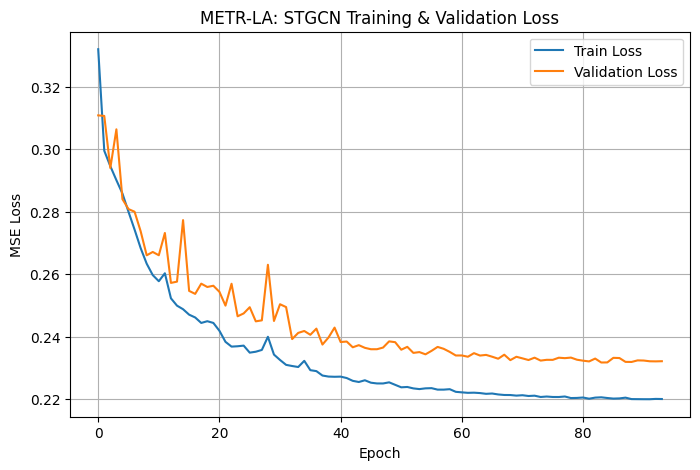

In [ ]:
plotTrainingHistory('METR-LA', train_loss_history, val_loss_history, dir_path)

Test MSE: 96.1763 | MAE: 5.3806 | RMSE: 9.8070 | WAPE: 10.6014


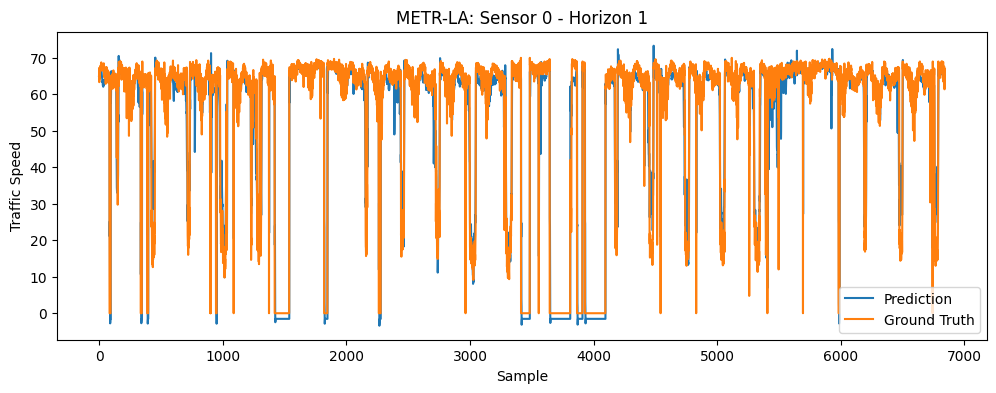

In [ ]:
evaluate('METR-LA', model, scaler, test_loader, dir_path, device)

In [ ]:
pemsbayKaggle = "scchuy/pemsbay"
pemsbayPklFile = 'adj_mx_bay.pkl'
pemsbayH5File = 'pems-bay.h5'

In [ ]:
train_df,   \
val_df,     \
test_df,    \
scaler,     \
sensor_ids, \
node_ids,   \
adj_matrix = loadAndPreprocess('pemsbay', pemsbayKaggle, pemsbayPklFile, pemsbayH5File, 'speed')

100%|██████████| 29.9M/29.9M [00:00<00:00, 84.8MB/s]

Extracting files...


Saved pemsbay data to /root/.cache/kagglehub/datasets/scchuy/pemsbay/versions/2
Loaded pemsbay graph with 325 sensors
pemsbay DataFrame shape: (52116, 325)
Imputing missing values
Aggregated pemsbay dataframe into 5 minute intervals with shape: (52128, 325)

Implementing 0.7:0.1:0.2 train:validation:test split
Scaling with StandardScaler()
test shape (36489, 325)
val shape (5212, 325)
test shape (10427, 325)


In [ ]:
X_train, Y_train = make_windows(train_df)
X_val,   Y_val   = make_windows(val_df)
X_test,  Y_test  = make_windows(test_df)

In [ ]:
train_loader = DataLoader(TrafficDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TrafficDataset(X_val,   Y_val), batch_size=64)
test_loader  = DataLoader(TrafficDataset(X_test,  Y_test), batch_size=64)

In [ ]:
model = STGCN(
    input_size=1,
    hidden_size=64,
    gcn_channels=16,
    num_layers=2,
    horizon=3,
    output_size=1,
    adj_matrix=adj_matrix.to(device)
)
model = model.to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.7,
    patience=3
)

early_stopper = EarlyStopping(patience=10, min_delta=1e-4)

epochs = 300

train_loss_history, val_loss_history = train(
    epochs,
    criterion,
    optimizer,
    scheduler,
    early_stopper,
    model,
    train_loader,
    val_loader,
    device
  )

Epoch 1 | Train Loss: 0.3785 | Val Loss: 0.4615
> Best model updated.
Epoch 2 | Train Loss: 0.3343 | Val Loss: 0.4535
> Best model updated.
Epoch 3 | Train Loss: 0.3276 | Val Loss: 0.4502
> Best model updated.
Epoch 4 | Train Loss: 0.3213 | Val Loss: 0.4332
> Best model updated.
Epoch 5 | Train Loss: 0.3157 | Val Loss: 0.4294
> Best model updated.
Epoch 6 | Train Loss: 0.3105 | Val Loss: 0.4244
> Best model updated.
Epoch 7 | Train Loss: 0.3080 | Val Loss: 0.4261
Epoch 8 | Train Loss: 0.3046 | Val Loss: 0.4196
> Best model updated.
Epoch 9 | Train Loss: 0.3023 | Val Loss: 0.4136
> Best model updated.
Epoch 10 | Train Loss: 0.2998 | Val Loss: 0.4116
> Best model updated.
Epoch 11 | Train Loss: 0.2974 | Val Loss: 0.4088
> Best model updated.
Epoch 12 | Train Loss: 0.2962 | Val Loss: 0.4084
> Best model updated.
Epoch 13 | Train Loss: 0.2938 | Val Loss: 0.4069
> Best model updated.
Epoch 14 | Train Loss: 0.2937 | Val Loss: 0.4034
> Best model updated.
Epoch 15 | Train Loss: 0.2918 | Val L

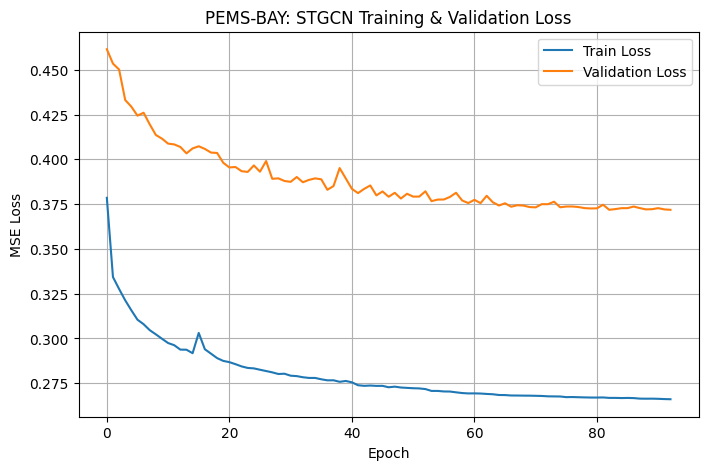

In [ ]:
plotTrainingHistory('PEMS-BAY', train_loss_history, val_loss_history, dir_path)

Test MSE: 18.9380 | MAE: 2.4443 | RMSE: 4.3518 | WAPE: 3.9130


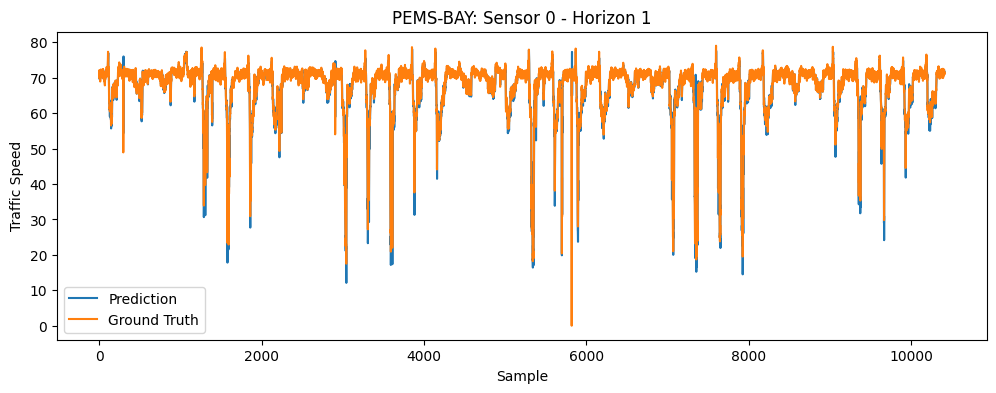

In [ ]:
evaluate('PEMS-BAY', model, scaler, test_loader, dir_path, device)